In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import gmean

import matplotlib.pyplot as plt
import seaborn as sns

from hmmlearn import hmm

### Volatility Regime Estimation with HMM

Estimate the current volatility regime and backtest a simple switch. use for the follwoign assets:
- TLT
- SPY
- GLD
- BTC
- USD/JPY

https://github.com/sweg44/Volatility-Modelling-Using-HiddenMarkovModels/blob/main/GOLD_VOLATILITY_STATE_MODELLING.ipynb


In [97]:
df = yf.download('GLD')

[*********************100%***********************]  1 of 1 completed


In [98]:
returns = np.log(df['Close']).diff()
returns.dropna(inplace=True)

### Build model

In [99]:
# 70 - 30 Train Test
split = int(0.3*len(returns))
X = returns[:-split]
X_test = returns[-split:]

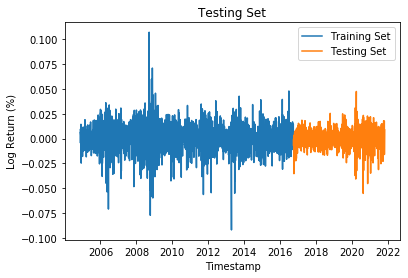

In [100]:
plt.plot(X, label='Training Set')
plt.plot(X_test, label='Testing Set')
plt.title(label='Testing Set')
plt.xlabel('Timestamp')
plt.ylabel('Log Return (%)')
plt.legend()
plt.show()

In [101]:
X = X.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy().reshape(-1, 1)

In [102]:
model = hmm.GaussianHMM(
    # 2 States
    n_components=2,
    covariance_type="diag",
    verbose=True
)

In [103]:
%%time
model.fit(X)

CPU times: user 128 ms, sys: 5.5 ms, total: 134 ms
Wall time: 108 ms


         1        7057.1157             +nan
         2        8855.2507       +1798.1350
         3        8869.3324         +14.0818
         4        8904.7247         +35.3923
         5        8946.6170         +41.8923
         6        8981.9560         +35.3390
         7        9007.0283         +25.0723
         8        9023.3351         +16.3069
         9        9033.7198         +10.3846
        10        9040.5440          +6.8242


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=True)

In [104]:
#set transmission probabilities
model.transmat_ = np.array(
    [
        [0.9, 0.1],
        [0.1, 0.9]
    ]
)

In [105]:
Z = model.predict(X_test)
Z_train = model.predict(X)

### Evaluating Model

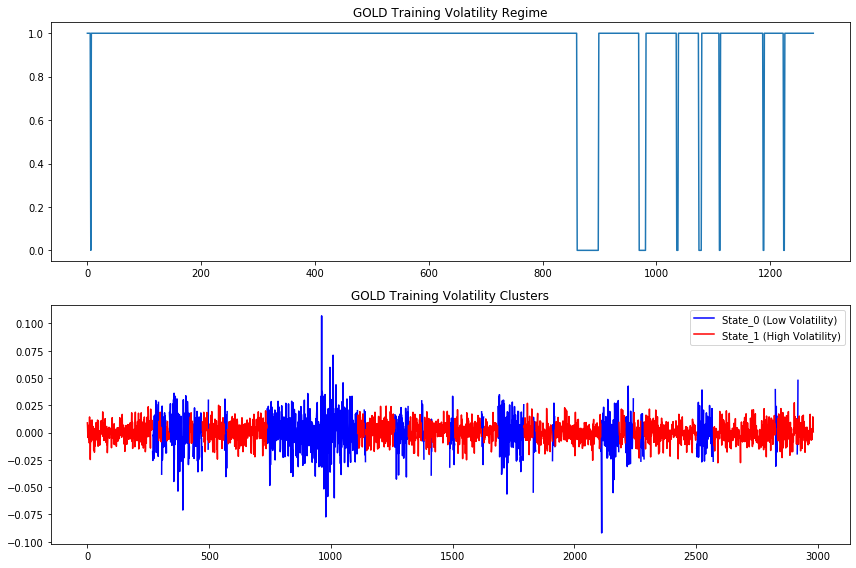

In [106]:
# Compute State Changes
returns_train0 = np.empty(len(Z_train))
returns_train1 = np.empty(len(Z_train))
returns_train0[:] = np.nan
returns_train1[:] = np.nan

# Create series for each state change
returns_train0[Z_train == 0] = returns[:-split][Z_train == 0]
returns_train1[Z_train == 1] = returns[:-split][Z_train == 1]


fig, ax = plt.subplots(figsize=(12,8))

# Plot the Volatility Regime and the states
plt.subplot(211)
plt.plot(Z)
plt.title(label='GOLD Training Volatility Regime')

plt.subplot(212)
plt.plot(returns_train0, label='State_0 (Low Volatility)', color='b')
plt.plot(returns_train1, label='State_1 (High Volatility)', color='r', )
plt.title(label='GOLD Training Volatility Clusters')
plt.legend()
plt.tight_layout()

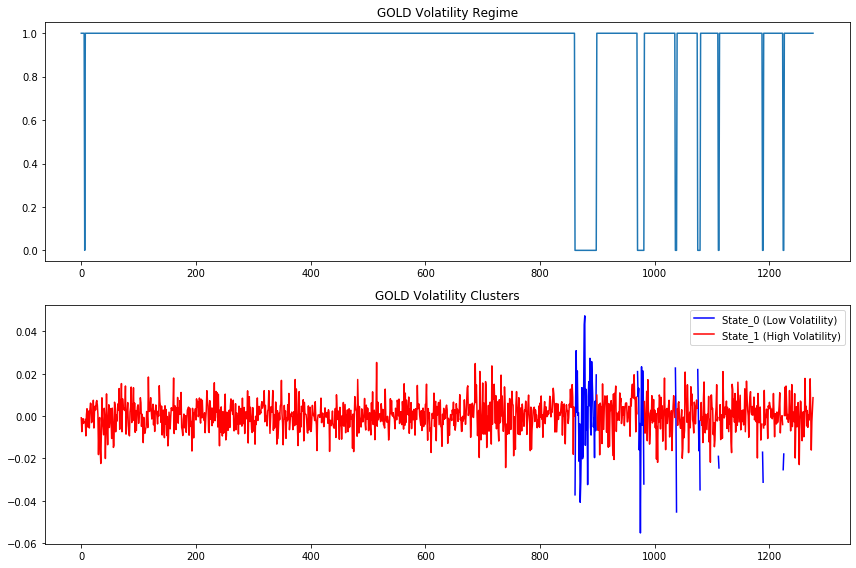

In [107]:
# Compute State Changes
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# Create series for each state change
returns0[Z == 0] = returns[-split:][Z == 0]
returns1[Z == 1] = returns[-split:][Z == 1]

# Plot the Volatility Regime and the states
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(211)
plt.plot(Z)
plt.title(label='GOLD Volatility Regime')

plt.subplot(212)
plt.plot(returns0, label='State_0 (Low Volatility)', color='b')
plt.plot(returns1, label='State_1 (High Volatility)', color='r')
plt.title(label='GOLD Volatility Clusters')

plt.legend()
plt.tight_layout()

## Test A switching Strategy out of sample

In [108]:
bck_df = pd.DataFrame(df['Close'][-split:])
bck_df.loc[:,'vol_state'] = Z
bck_df.loc[:,'ret'] = bck_df['Close'].pct_change().shift(-1)

bck_df = bck_df.dropna()
bck_df.loc[:,'strat'] = bck_df[bck_df['vol_state'] == 0]['ret']
bck_df.loc[:,'strat'] = bck_df.loc[:,'strat'].fillna(0)

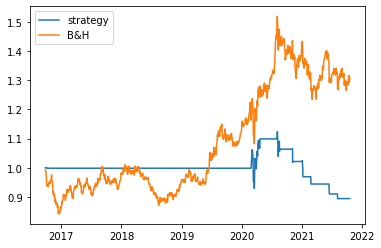

In [109]:
plt.plot((bck_df['strat']+1).cumprod(), label ='strategy' );
plt.plot((bck_df['ret']+1).cumprod(), label = 'B&H');
plt.legend();